<a href="https://colab.research.google.com/github/AllergictoCrustaceans/ML/blob/main/multilabel_classification_fetal_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify Fetal Health

Prompt: Given patients' cardiotocograms (CTGs) data, predict the patient's fetal health (normal, suspect, pathological).

Where is data from: https://www.kaggle.com/andrewmvd/fetal-health-classification

ML Type: Compare Random Forest Classifer V. keras.layers model, Added Weights

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean, std

!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp37-none-any.whl size=73269 sha256=3f392731e40a9f6134c9e11a07ff5961f0fd0161d9381e92d56fa54da95a2813
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


### 1.) Connect to Kaggle API

In [2]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                       title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           4253        125  1.0              
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    9MB  2021-02-28 06:57:50           1957        272  1.0              
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            389         20  1.0              
aagghh/crypto-telegram-groups                             Crypto telegram groups           

### 2.) Load Kaggle Dataset

In [4]:
!kaggle datasets download -d andrewmvd/fetal-health-classification --unzip

  0% 0.00/45.8k [00:00<?, ?B/s]
100% 45.8k/45.8k [00:00<00:00, 25.3MB/s]


In [5]:
ds_raw = pd.read_csv('/content/fetal_health.csv')

### 3.) Inspect

In [6]:
# Check dtype, nulls.
ds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

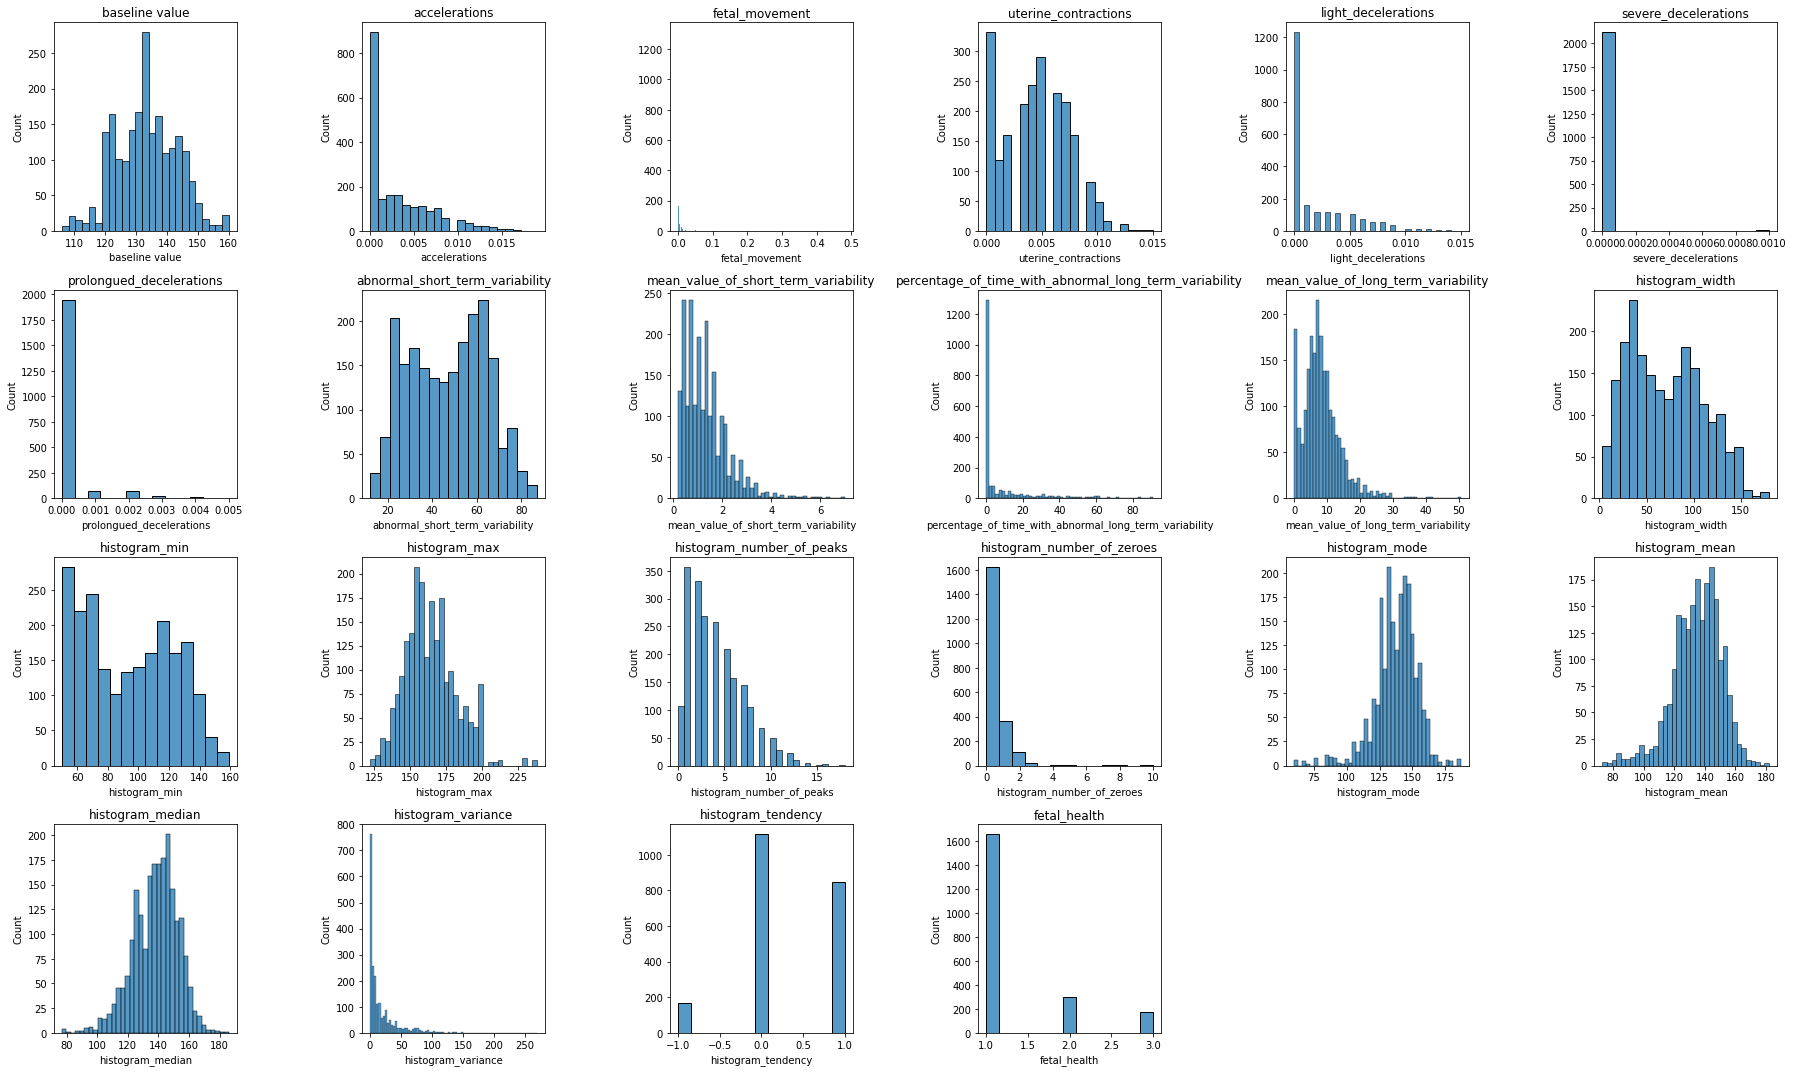

In [9]:
# Check distribution of features

plt.figure(figsize=(25, 15))

for i, column in enumerate(ds_raw.columns):
    plt.subplot(4, 6, i+1)
    sns.histplot(data=ds_raw[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Based off of the graphs, it seems like majority of the features are normally distirbuted. The only few feautres that are skewed 'accelerations', 'light_accelerations', 'severe decerlations', 'prolonged_decelerations', and 'mean_value_of_short_term_variability'.

As for the histogram features, I wonder what they are specifically histograms of.

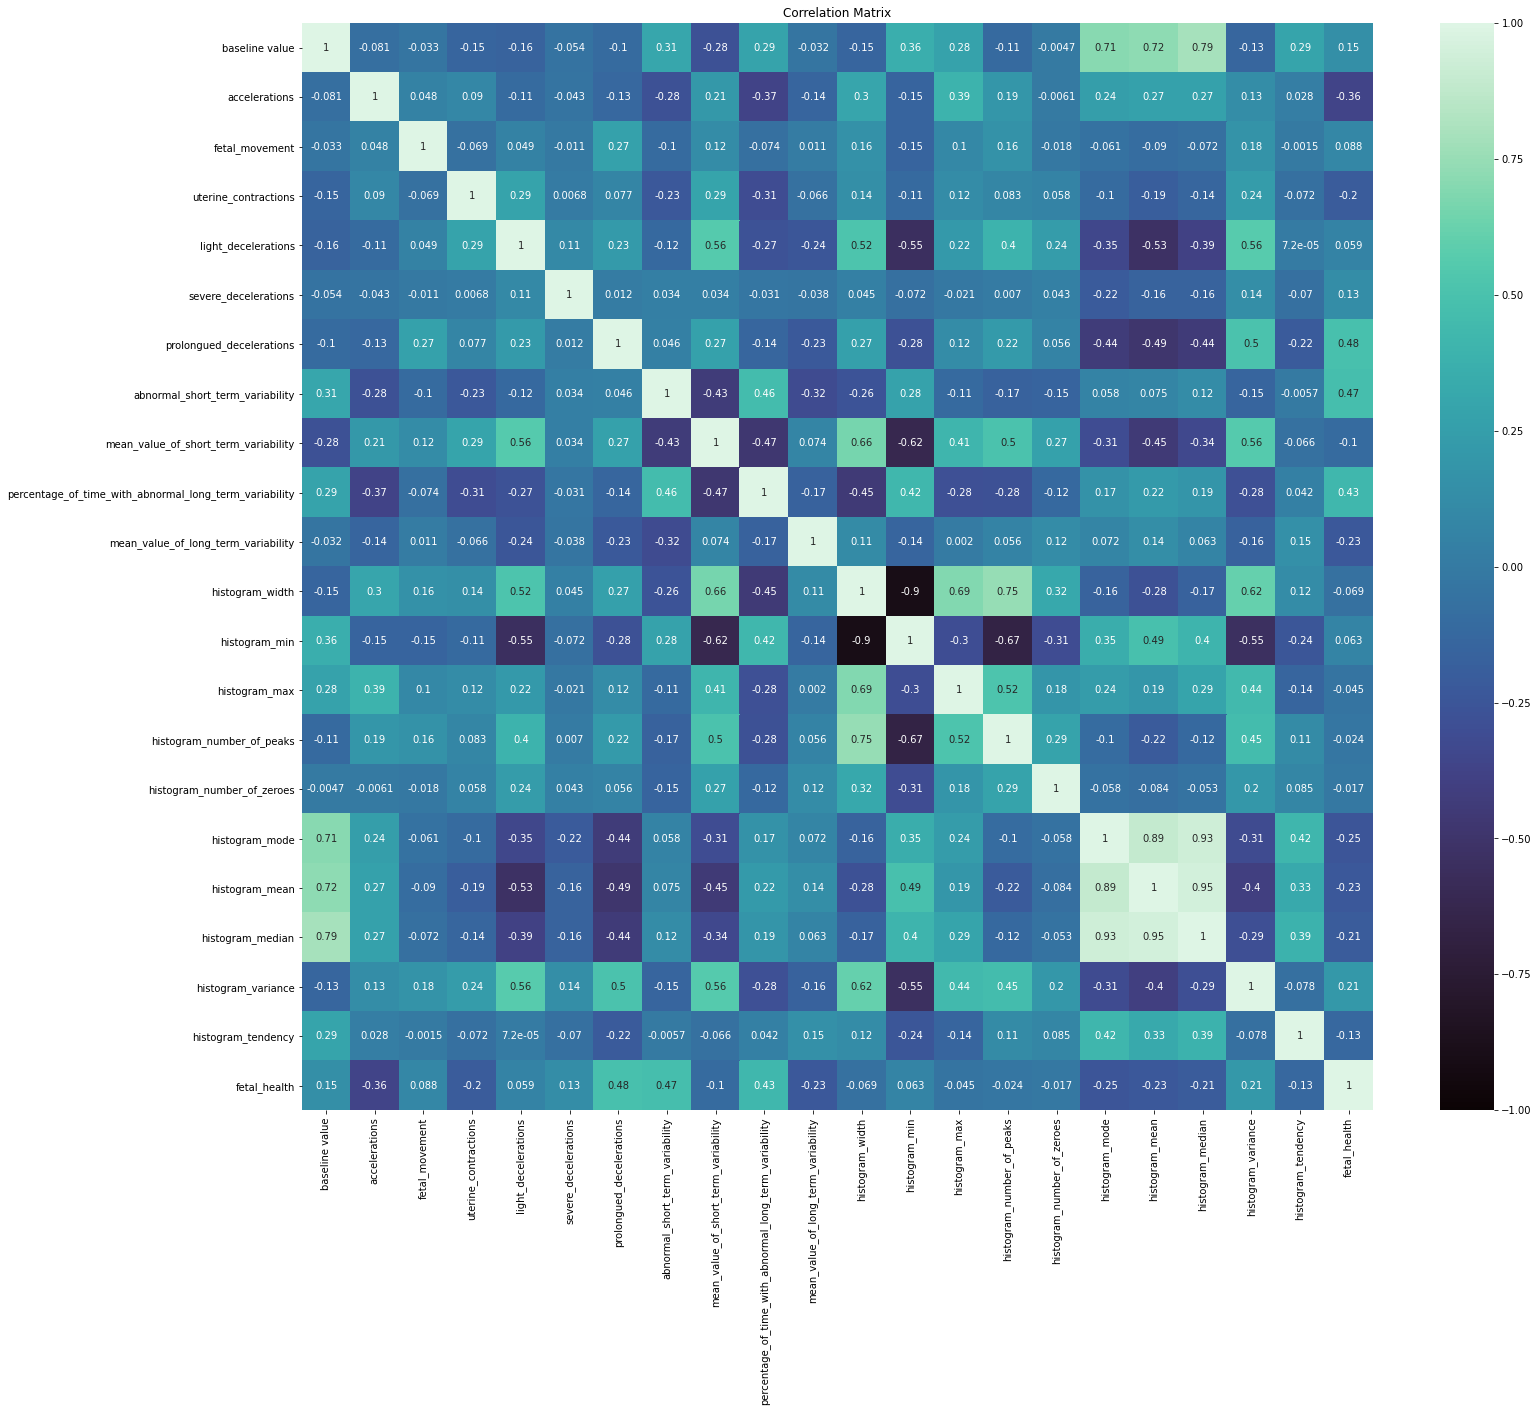

In [11]:
# Check feature redundancy via correlatio matrix
corr = ds_raw.corr()

plt.figure(figsize=(24, 20))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.title('Correlation Matrix')
plt.show()

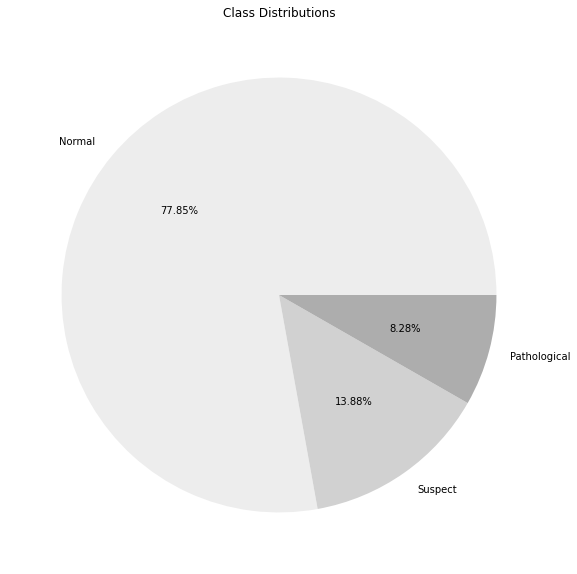

In [12]:
# Check data imbalance
plt.figure(figsize=(10, 10))

plt.pie(ds_raw['fetal_health'].value_counts(),
       autopct='%0.2f%%',
       labels=['Normal', 'Suspect', 'Pathological'],
       colors=sns.color_palette('Greys'))

plt.title('Class Distributions')
plt.show()

### 4.) Split

In [13]:
ds = ds_raw.copy()

train_df, test_df = train_test_split(ds, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

y_train = np.array(train_df.pop('fetal_health'))
bool_y_train = y_train != 0
y_val = np.array(val_df.pop('fetal_health'))
y_test = np.array(test_df.pop('fetal_health'))

x_train = np.array(train_df)
x_test = np.array(test_df)
x_val = np.array(val_df)

### 5.) Preprocess

In [14]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_val = scaler.fit_transform(x_val)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

In [15]:
# Check dataset shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((1360, 21), (1360,), (426, 21), (426,), (340, 21), (340,))

### 6.) Build Model

In [16]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

def build(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[-1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation='softmax', bias_initializer=output_bias)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=metrics)
    
    return model


EPOCHS=100
BATCH_SIZE=200

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [17]:
model = build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                352       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


### 7.) Train Plain Model with Weight Initialization


In [18]:
count = ds['fetal_health'].value_counts()
total = count.sum()
normal = count[1]
suspect = count[2]
patho = count[3]

In [19]:
weight_for_0 = (1 / normal) * (total) / 3.0
weight_for_1 = (1 / suspect) * (total) / 3.0
weight_for_2 = (1 / patho) * (total) / 3.0

class_weight = {
    0: weight_for_0,
    1: weight_for_1,
    2: weight_for_2
}

print('weight for class 0: {:0.2f}'.format(weight_for_0))
print('weight for class 1: {:0.2f}'.format(weight_for_1))
print('weight for class 2: {:0.2f}'.format(weight_for_2))

weight for class 0: 0.43
weight for class 1: 2.40
weight for class 2: 4.03


In [20]:
# One-hot-encode y_train, y_test, y_val
y_train_ohe = tf.keras.utils.to_categorical(y_train, 3)
y_test_ohe = tf.keras.utils.to_categorical(y_test, 3)
y_val_ohe = tf.keras.utils.to_categorical(y_val, 3)

weighted_model = build()

weighted_history = weighted_model.fit(
    x_train,
    y_train_ohe,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data = (x_val, y_val_ohe),
    class_weight=class_weight
)

Epoch 1/100
7/7 [==============================] - 3s 153ms/step - loss: 1.4926 - tp: 220.6250 - tn: 1499.6250 - fp: 230.3750 - fn: 644.3750 - accuracy: 0.6646 - precision: 0.4937 - recall: 0.2610 - auc: 0.6575 - val_loss: 0.9916 - val_tp: 73.0000 - val_tn: 621.0000 - val_fp: 59.0000 - val_fn: 267.0000 - val_accuracy: 0.6804 - val_precision: 0.5530 - val_recall: 0.2147 - val_auc: 0.7023
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 1.2909 - tp: 216.8750 - tn: 1525.1250 - fp: 204.8750 - fn: 648.1250 - accuracy: 0.6723 - precision: 0.5173 - recall: 0.2521 - auc: 0.6723 - val_loss: 0.9708 - val_tp: 70.0000 - val_tn: 631.0000 - val_fp: 49.0000 - val_fn: 270.0000 - val_accuracy: 0.6873 - val_precision: 0.5882 - val_recall: 0.2059 - val_auc: 0.7161
Epoch 3/100
7/7 [==============================] - 0s 12ms/step - loss: 1.2263 - tp: 220.3750 - tn: 1543.5000 - fp: 186.5000 - fn: 644.6250 - accuracy: 0.6784 - precision: 0.5378 - recall: 0.2508 - auc: 0.6791 - val_loss:

#### Evaluate 

In [28]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                    color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

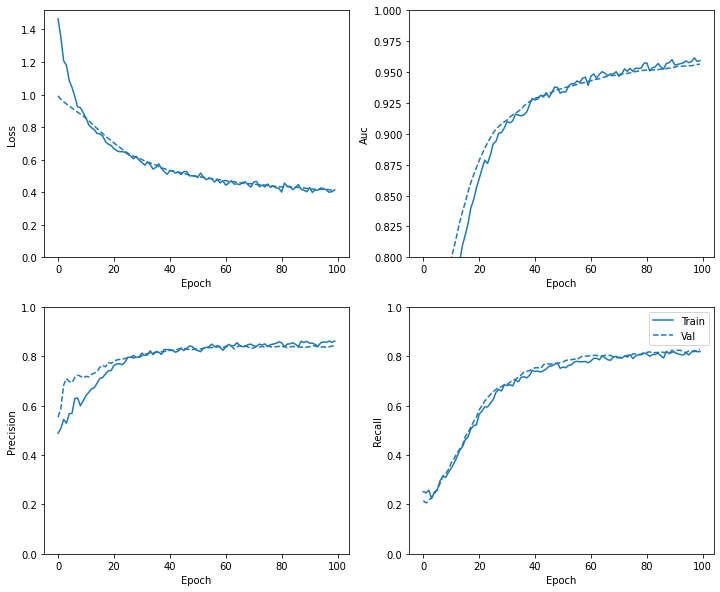

In [29]:
plot_metrics(weighted_history)

Based off of the graphs, the training and val loss are really similar, both hovering around a loss of 0.4. Similarly in other metrics, both the training and val dataset are hovering around similar values. 

#### Random Forest Classifier with balanced weights

In [21]:
def evaluate_model(x, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv = cv, n_jobs=1)
    return scores

cost_sen_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
scores = evaluate_model(x_train, y_train, cost_sen_model)

In [22]:
print('Mean accuracy: %0.3f (%0.3f)' % (mean(scores), std(scores)))

Mean accuracy: 0.929 (0.013)


#### Random Forest Classifer With Customized Weights

In [24]:
cost_sen_model_custom_weights = RandomForestClassifier(n_estimators=1000, class_weight=class_weight)
scores = evaluate_model(x_train, y_train, cost_sen_model_custom_weights)
print('Mean accuracy: %0.3f (%0.3f)' % (mean(scores), std(scores)))

Mean accuracy: 0.929 (0.014)


The goal of this ML problem was to find out if there was any performance difference when training a model via Random Forest Classifier, or with own simple keras layers implemented. 

When trained with Random Forest Classifier, the model seems to have performed about the same with balanced/customized weights, with a mean accuracy of 92%. 

Some things to consider:

- How to plot the confusion matrix for a multilabel dataset?